In [1]:
from RandomPhaseGenerator import RandomPhase, kShell
from PowerSpectrum import PowerSpectrum, TwoPoint, PsiK
import numpy as np
from SchroPoissonSolver import fdmSimulation
import scipy as sp
import gc
import matplotlib.pyplot as plt


In [2]:
N = 256
L = 1# box size

kvals0 = np.fft.fftshift(2*np.fft.fftfreq(N)*N*np.pi/L)

k_min = 2*np.pi/L
k_max = 2*np.pi*N/L

# thin shell:
k_shell = 50*k_min 
k_width = k_shell/20 

psi0, _, _ = kShell(resolution=N,
                      box_size = L,
                      kshell = k_shell,
                      kwidth = k_width,
                      random_phase = True)

t_shell = 1/(2*k_shell**2)# de Broglie osc. time
dt = (L/N)**2/(2*np.pi) #/ time step

norm = 500 # avg density
g_max = 10 # max coupling

couplings = g_max*np.array([0, -1, 1])


t_v = 1/(2*g_max*norm)
eps_max = g_max*norm*1/np.max([k_width**2 , (k_shell)**2])
t_therm = t_v/eps_max
epsilons = couplings*norm/np.max([k_width**2 , (k_shell)**2])


Text(0, 0.5, '$k_y \\ [k_{*}]$')

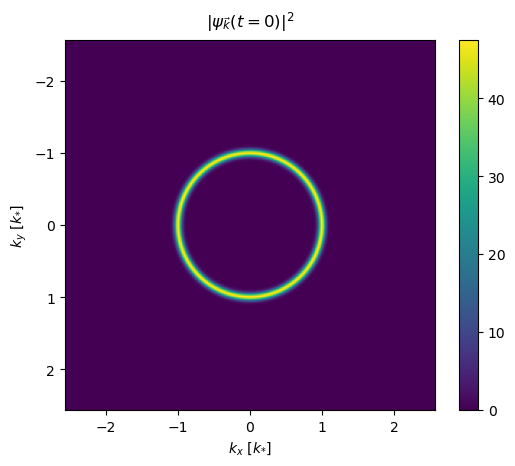

In [3]:
_,_,test = np.abs(PsiK(psi0, L))**2

plt.figure()
plt.title(r"$|\psi_{\vec{k}}(t=0)|^2$", pad=10)
plt.imshow(test/np.average(test), extent = [-k_max/2/k_shell , k_max/2/k_shell, k_max/2/k_shell , -k_max/2/k_shell])
plt.colorbar()
plt.xlabel(r"$k_x \ [k_{*}]$")
plt.ylabel(r"$k_y \ [k_{*}]$")

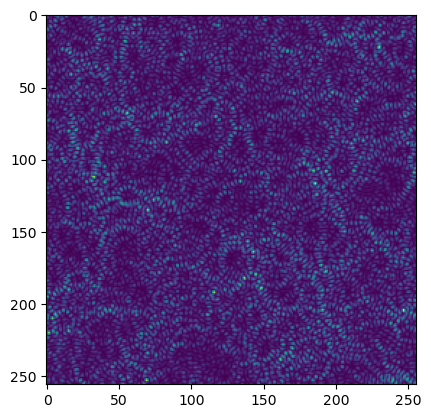

In [4]:
plt.imshow(np.abs(psi0)**2)

In [5]:
tf = 3*t_therm#2*np.pi/(2*norm*g_max)
t_vals = np.arange(0, tf, dt)
t_saved = np.array([t_shell, 2*t_shell, 0.5*t_v, t_v, 1.5*t_v, 2*t_v, 5*t_v,
                    0.5*t_therm, t_therm, 1.5*t_therm, 2*t_therm, tf])

psis = []
deltas = []

for g in couplings:
    trecorded, delta, psi = fdmSimulation(psi0 = psi0, normalization = norm,
                                                       L = L, G_N = 0, g_SI = g,
                                                       tvals = t_vals, tsaved = t_saved)
    psis.append(psi)
    deltas.append(delta)
    

In [6]:
save = False
if save:
    # open a file in write mode
    with open('Simulations//params.txt', 'w') as file:
        # write variables using repr() function
        file.write("resolution = " + repr(N) + '\n')
        file.write("k_nyq = " + repr(k_max) + '\n')
        file.write("k_shell = " + repr(k_shell) + '\n')
        file.write("k_width = " + repr(k_width) + '\n')
        file.write("rho_avg = " + repr(norm) + '\n')
        file.write("g_max = " + repr(g_max) + '\n')
        file.write("t_shell = " + repr(t_shell) + '\n')
        file.write("t_v = " + repr(t_v) + '\n')
        file.write("t_therm = " + repr(t_therm) + '\n')
        file.write("dt = " + repr(dt) + '\n')
        file.write("t_final = " + repr(tf) + '\n')
    np.save("Simulations//psi-array.npy", np.asarray(psis))
    np.save("Simulations//delta-array.npy", np.asarray(deltas))
    np.save("Simulations//coupling-array.npy", np.asarray(couplings))
    np.save("Simulations//t-recorded.npy", trecorded)
    np.save("Simulations//t-vals.npy", t_vals)



## Plot final time density power

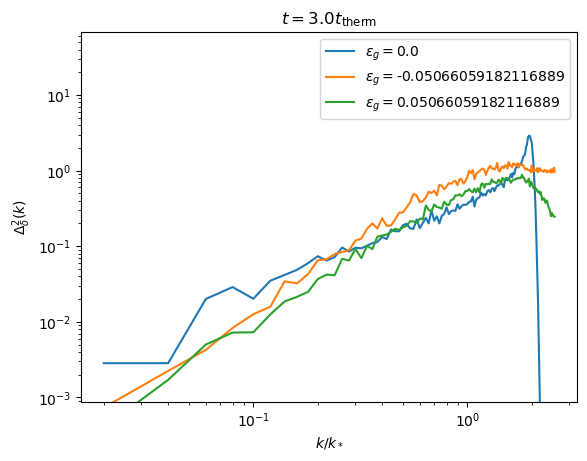

In [7]:
plt.figure()
plt.title(r"$t=$"+str(tf/t_therm)+r"$t_{\rm therm}$")
for i in range(len(epsilons)):

    k_radial, density_power = PowerSpectrum(np.abs(psis[i][-1])**2, L)

    plt.plot(k_radial/k_shell, k_radial**2*density_power/(2*np.pi), label=r"$\epsilon_g=$"+str(epsilons[i]))
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3*np.max(k_radial**2*density_power/(2*np.pi)))

plt.xlabel(r"$k/k_*$")
plt.ylabel(r"$\Delta^2_{\delta}(k)$")
plt.legend()
plt.show()

## Plot final time field power

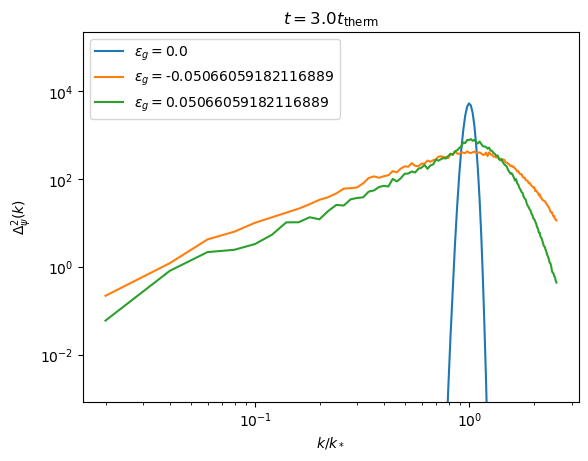

In [10]:
plt.figure()
plt.title(r"$t=$"+str(tf/t_therm)+r"$t_{\rm therm}$")
for i in range(len(epsilons)):

    k_radial, field_power = TwoPoint(psis[i][-1], L)

    plt.plot(k_radial/k_shell, k_radial**2*field_power/(2*np.pi), label=r"$\epsilon_g=$"+str(epsilons[i]))
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-3*np.max(k_radial**2*density_power/(2*np.pi)))

plt.xlabel(r"$k/k_*$")
plt.ylabel(r"$\Delta^2_{\psi}(k)$")
plt.legend()
plt.show()